# 4. Model Interpretability
Interpretability for models trained on the Hugging Face dataset `chen1028/Cl-Containing-Compound` features.

## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import shap

repo_id = "chen1028/Cl-Containing-Compound"
train_url = f"https://huggingface.co/datasets/{repo_id}/resolve/main/train.csv"
test_url = f"https://huggingface.co/datasets/{repo_id}/resolve/main/test.csv"

# Load from HF
ds = load_dataset(
  "csv",
  data_files={
    "train": "hf://datasets/chen1028/Cl-Containing-Compound/train.csv",
    "test":  "hf://datasets/chen1028/Cl-Containing-Compound/test.csv",
  }
)

# Convert to pandas
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()

# train_df = train_df[:1000]
# test_df = test_df[:1000]

# Derive label from 'Cl' for both splits if needed
def _to_binary_cl(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce").fillna(0)
    return (s != 0).astype(int)

if "has_cl" not in train_df.columns:
    if "Cl" in train_df.columns:
        train_df["has_cl"] = _to_binary_cl(train_df["Cl"])
    else:
        raise KeyError("Expected 'Cl' or 'has_cl' in dataset columns (train).")

if "has_cl" not in test_df.columns:
    if "Cl" in test_df.columns:
        test_df["has_cl"] = _to_binary_cl(test_df["Cl"])
    else:
        raise KeyError("Expected 'Cl' or 'has_cl' in dataset columns (test).")

# Choose feature columns, excluding label/leaky/non-numeric identifiers
exclude_cols = {"has_cl", "Cl", "MF", "mode"}
train_feats = train_df.drop(columns=[c for c in train_df.columns if c in exclude_cols], errors="ignore")
test_feats = test_df.drop(columns=[c for c in test_df.columns if c in exclude_cols], errors="ignore")

# Coerce to numeric
train_feats = train_feats.apply(pd.to_numeric, errors="coerce")
test_feats = test_feats.apply(pd.to_numeric, errors="coerce")

# Align columns: use intersection and sort for consistent order
common_cols = sorted(list(set(train_feats.columns).intersection(set(test_feats.columns))))
train_feats = train_feats[common_cols]
test_feats = test_feats[common_cols]

# Drop columns that are entirely NaN in both splits
all_nan_cols = [c for c in common_cols if train_feats[c].isna().all() and test_feats[c].isna().all()]
if all_nan_cols:
    train_feats = train_feats.drop(columns=all_nan_cols)
    test_feats = test_feats.drop(columns=all_nan_cols)

# Impute (fit on train), then scale (fit on train)
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(train_feats)
X_test_imputed = imputer.transform(test_feats)

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Targets and feature names
y_train = train_df["has_cl"].astype(int).values
y_test = test_df["has_cl"].astype(int).values
feature_names = list(train_feats.columns)

# DataFrames for SHAP/plotting convenience
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

print("HF dataset prepared.")
print("Train size:", X_train_df.shape, "Test size:", X_test_df.shape)
print("Positive rate (train/test):", y_train.mean(), y_test.mean())

HF dataset prepared.
Train size: (618272, 27) Test size: (154568, 27)
Positive rate (train/test): 0.5006647559650121 0.4973409761399514


## 1. Understanding Model Interpretability

**White Box Models** (Intrinsically Interpretable):
- Linear/Logistic Regression: Coefficients directly indicate feature importance
- Decision Trees: Rules are transparent and human-readable
- Naive Bayes: Probabilistic relationships are clear

**Black Box Models** (Require Interpretation Techniques):
- Random Forest: Ensemble of trees with complex interactions
- SVM: Complex decision boundaries in high-dimensional space
- Neural Networks: Multiple layers of non-linear transformations

Let's create a dataset and demonstrate both types of models.

In [2]:
# Using Hugging Face dataset prepared above (train/test already split)
print(f"HF Train shape: {X_train_df.shape}")
print(f"HF Test shape: {X_test_df.shape}")
print(f"HF Feature count: {len(feature_names)}")
unique, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(unique.tolist(), counts.tolist())))
unique_t, counts_t = np.unique(y_test, return_counts=True)
print("Test class distribution:", dict(zip(unique_t.tolist(), counts_t.tolist())))

HF Train shape: (618272, 27)
HF Test shape: (154568, 27)
HF Feature count: 27
Train class distribution: {0: 308725, 1: 309547}
Test class distribution: {0: 77695, 1: 76873}


## 2. White Box Models: Intrinsic Interpretability

We'll train interpretable models directly on the Hugging Face dataset (using the prepared train/test splits).

### Feature Glossary (Replace / Extend with Domain Knowledge)
Below is a placeholder template for explaining the meaning of each feature. Fill in biological or analytical context so readers understand why a feature might relate to chlorine presence.

| Feature | Description (example) |
|---------|-----------------------|
| feature_1 | Peak intensity of metabolite X (m/z ~123.45) |
| feature_2 | Retention time aligned intensity for metabolite Y |
| ... | ... |

How to complete:
1. Map feature names to metabolite IDs or m/z-retention time pairs.
2. Group features into biochemical pathways where possible.
3. Highlight any features known to bind or correlate with halogenated compounds.

Providing this table greatly improves interpretability and scientific credibility.

### 2.1 Logistic Regression: Coefficient Analysis

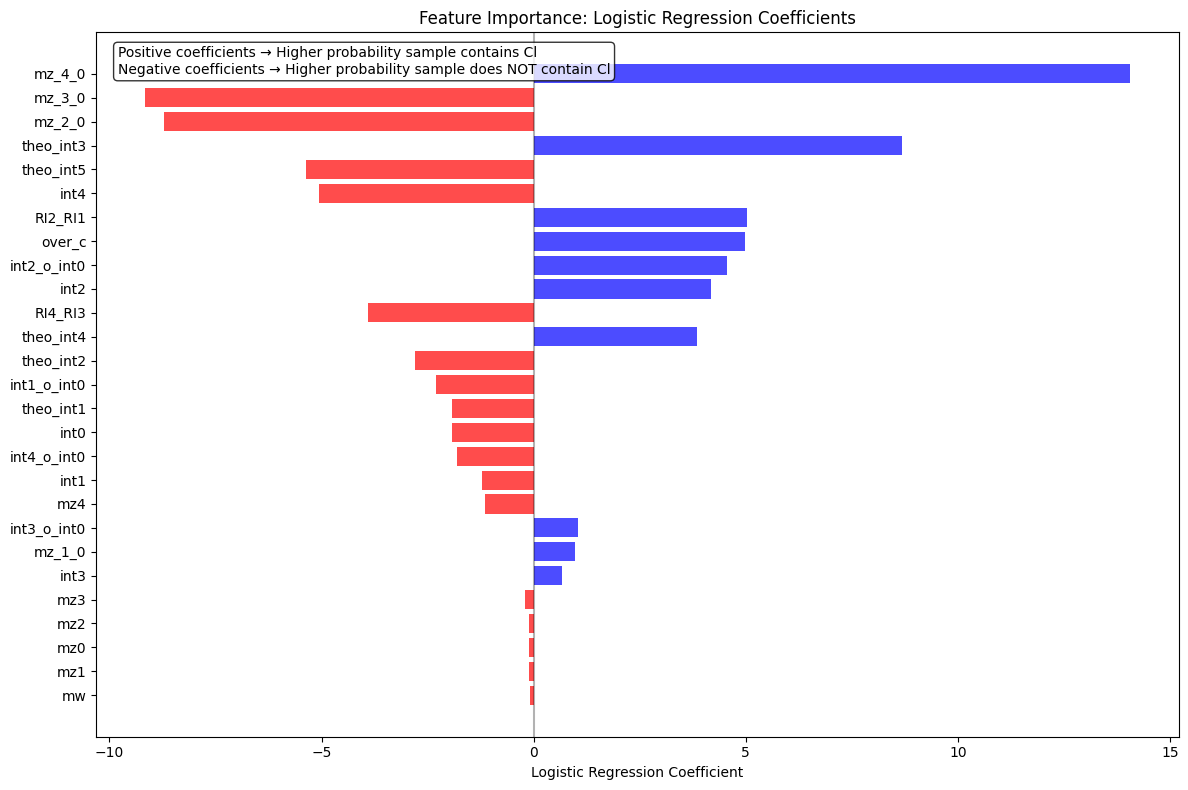

Logistic Regression Accuracy: 1.000

Model Equation (simplified):
P(contains Cl) = 1 / (1 + exp(-(-0.026 + Σ(coef_i × feature_i))))

Top 3 metabolites associated with Cl presence:
  mz_4_0: 14.050
  theo_int3: 8.678
  RI2_RI1: 5.025

Top 3 metabolites associated with no Cl:
  mz_3_0: -9.155
  mz_2_0: -8.708
  theo_int5: -5.375


In [3]:
# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Get coefficients
coefficients = lr_model.coef_[0]
intercept = lr_model.intercept_[0]

# Create coefficient DataFrame
coef_df = pd.DataFrame({
    'Metabolite': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=True)

# Visualize coefficients
plt.figure(figsize=(12, 8))
colors = ['red' if c < 0 else 'blue' for c in coef_df['Coefficient']]
bars = plt.barh(coef_df['Metabolite'], coef_df['Coefficient'], color=colors, alpha=0.7)

plt.xlabel('Logistic Regression Coefficient')
plt.title('Feature Importance: Logistic Regression Coefficients')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add interpretation text
plt.text(0.02, 0.98, 
         'Positive coefficients → Higher probability sample contains Cl\n' +
         'Negative coefficients → Higher probability sample does NOT contain Cl',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print model performance and interpretation
lr_accuracy = accuracy_score(y_test, lr_model.predict(X_test_scaled))
print(f"Logistic Regression Accuracy: {lr_accuracy:.3f}")
print(f"\nModel Equation (simplified):")
print(f"P(contains Cl) = 1 / (1 + exp(-({intercept:.3f} + Σ(coef_i × feature_i))))")

# Top positive and negative features
print(f"\nTop 3 metabolites associated with Cl presence:")
top_positive = coef_df.nlargest(3, 'Coefficient')
for _, row in top_positive.iterrows():
    print(f"  {row['Metabolite']}: {row['Coefficient']:.3f}")

print(f"\nTop 3 metabolites associated with no Cl:")
top_negative = coef_df.nsmallest(3, 'Coefficient')
for _, row in top_negative.iterrows():
    print(f"  {row['Metabolite']}: {row['Coefficient']:.3f}")

### 2.2 Decision Tree: Rule Extraction

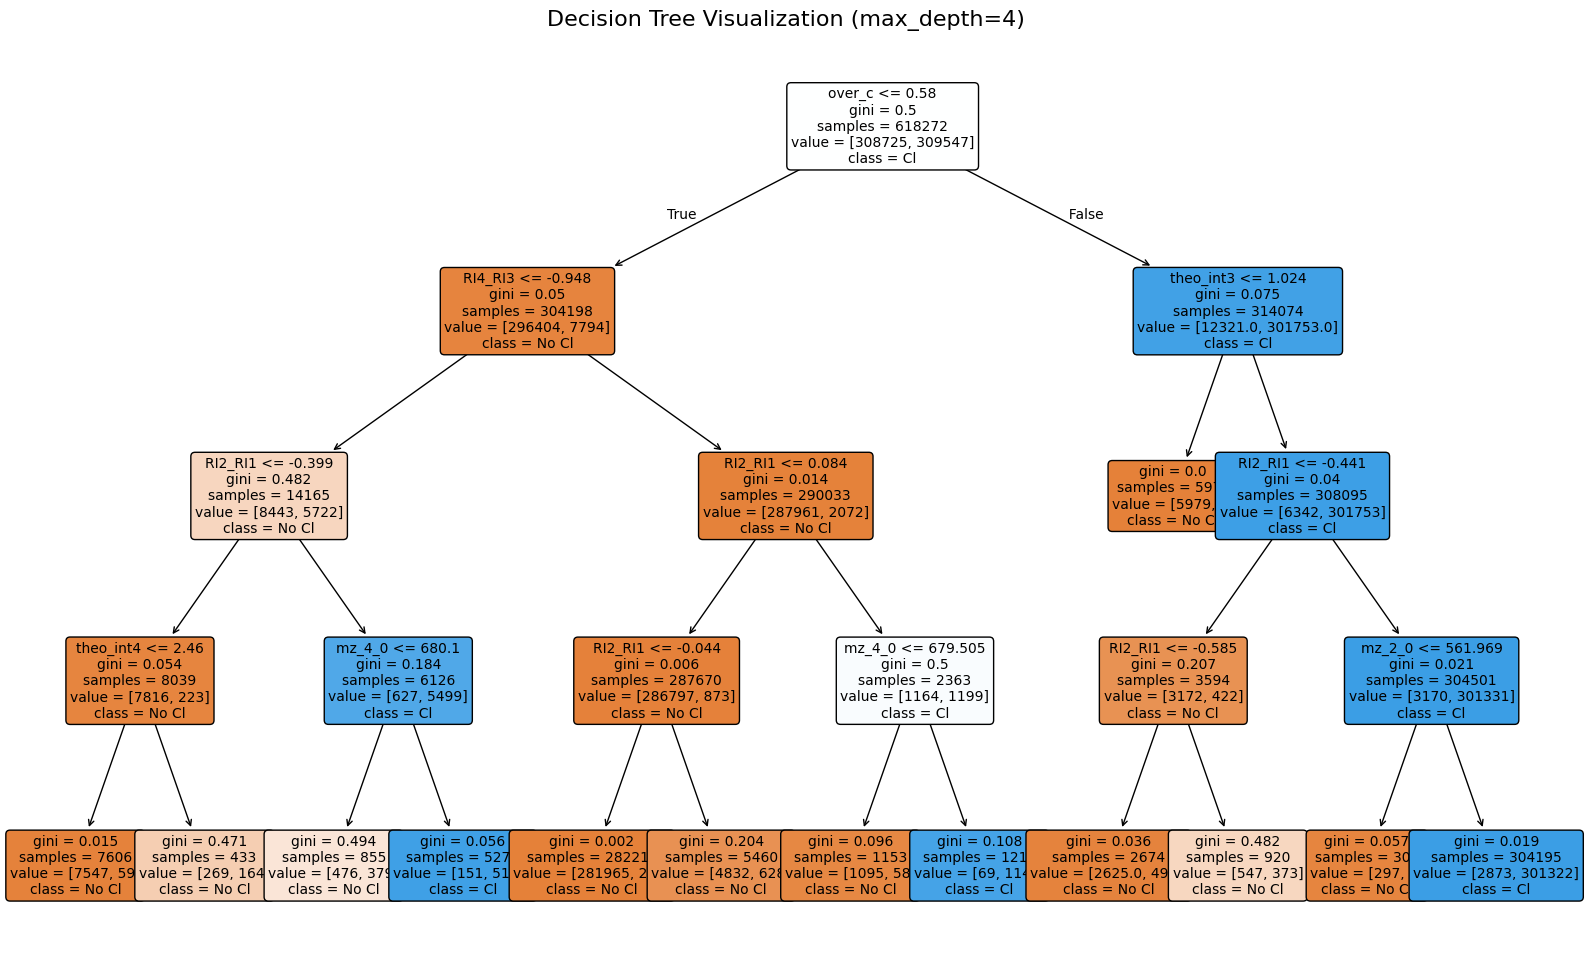

Decision Tree Rules:
Rule 1:
  IF over_c <= 0.580 AND RI4_RI3 <= -0.948 AND RI2_RI1 <= -0.399 AND theo_int4 <= 2.460
  THEN Prediction: No Cl
  Confidence: 0.992
  Training samples: 1

Rule 2:
  IF over_c <= 0.580 AND RI4_RI3 <= -0.948 AND RI2_RI1 <= -0.399 AND theo_int4 > 2.460
  THEN Prediction: No Cl
  Confidence: 0.621
  Training samples: 1

Rule 3:
  IF over_c <= 0.580 AND RI4_RI3 <= -0.948 AND RI2_RI1 > -0.399 AND mz_4_0 <= 680.100
  THEN Prediction: No Cl
  Confidence: 0.557
  Training samples: 1

Rule 4:
  IF over_c <= 0.580 AND RI4_RI3 <= -0.948 AND RI2_RI1 > -0.399 AND mz_4_0 > 680.100
  THEN Prediction: Cl
  Confidence: 0.971
  Training samples: 1

Rule 5:
  IF over_c <= 0.580 AND RI4_RI3 > -0.948 AND RI2_RI1 <= 0.084 AND RI2_RI1 <= -0.044
  THEN Prediction: No Cl
  Confidence: 0.999
  Training samples: 1

Rule 6:
  IF over_c <= 0.580 AND RI4_RI3 > -0.948 AND RI2_RI1 <= 0.084 AND RI2_RI1 > -0.044
  THEN Prediction: No Cl
  Confidence: 0.885
  Training samples: 1

Rule 7:
  I

In [4]:
# Train a simple decision tree for interpretability
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42, min_samples_split=20)
dt_model.fit(X_train_scaled, y_train)

# Visualize the decision tree
plt.figure(figsize=(20, 12))
plot_tree(dt_model, 
          feature_names=feature_names,
          class_names=['No Cl', 'Cl'],
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Visualization (max_depth=4)', fontsize=16)
plt.show()

# Extract decision rules
def extract_rules(tree, feature_names, class_names):
    """
    Extract human-readable rules from a decision tree.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []
    
    def recurse(node, rule_conditions):
        if tree_.feature[node] != -2:  # Not a leaf
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # Left child (<=)
            left_conditions = rule_conditions + [f"{name} <= {threshold:.3f}"]
            recurse(tree_.children_left[node], left_conditions)
            
            # Right child (>)
            right_conditions = rule_conditions + [f"{name} > {threshold:.3f}"]
            recurse(tree_.children_right[node], right_conditions)
        else:  # Leaf node
            # Get the class prediction
            class_counts = tree_.value[node][0]
            predicted_class = np.argmax(class_counts)
            confidence = class_counts[predicted_class] / np.sum(class_counts)
            
            rule = {
                'conditions': ' AND '.join(rule_conditions),
                'prediction': class_names[predicted_class],
                'confidence': confidence,
                'samples': int(np.sum(class_counts))
            }
            rules.append(rule)
    
    recurse(0, [])
    return rules

# Extract and display rules
rules = extract_rules(dt_model, feature_names, ['No Cl', 'Cl'])

print("Decision Tree Rules:")
print("=" * 80)
for i, rule in enumerate(rules, 1):
    print(f"Rule {i}:")
    print(f"  IF {rule['conditions']}")
    print(f"  THEN Prediction: {rule['prediction']}")
    print(f"  Confidence: {rule['confidence']:.3f}")
    print(f"  Training samples: {rule['samples']}")
    print()

# Model performance
dt_accuracy = accuracy_score(y_test, dt_model.predict(X_test_scaled))
print(f"Decision Tree Accuracy: {dt_accuracy:.3f}")

## 3. Feature Importance for Black Box Models

For more complex models, we need specialized techniques to understand feature importance.

### 3.1 Random Forest Feature Importance

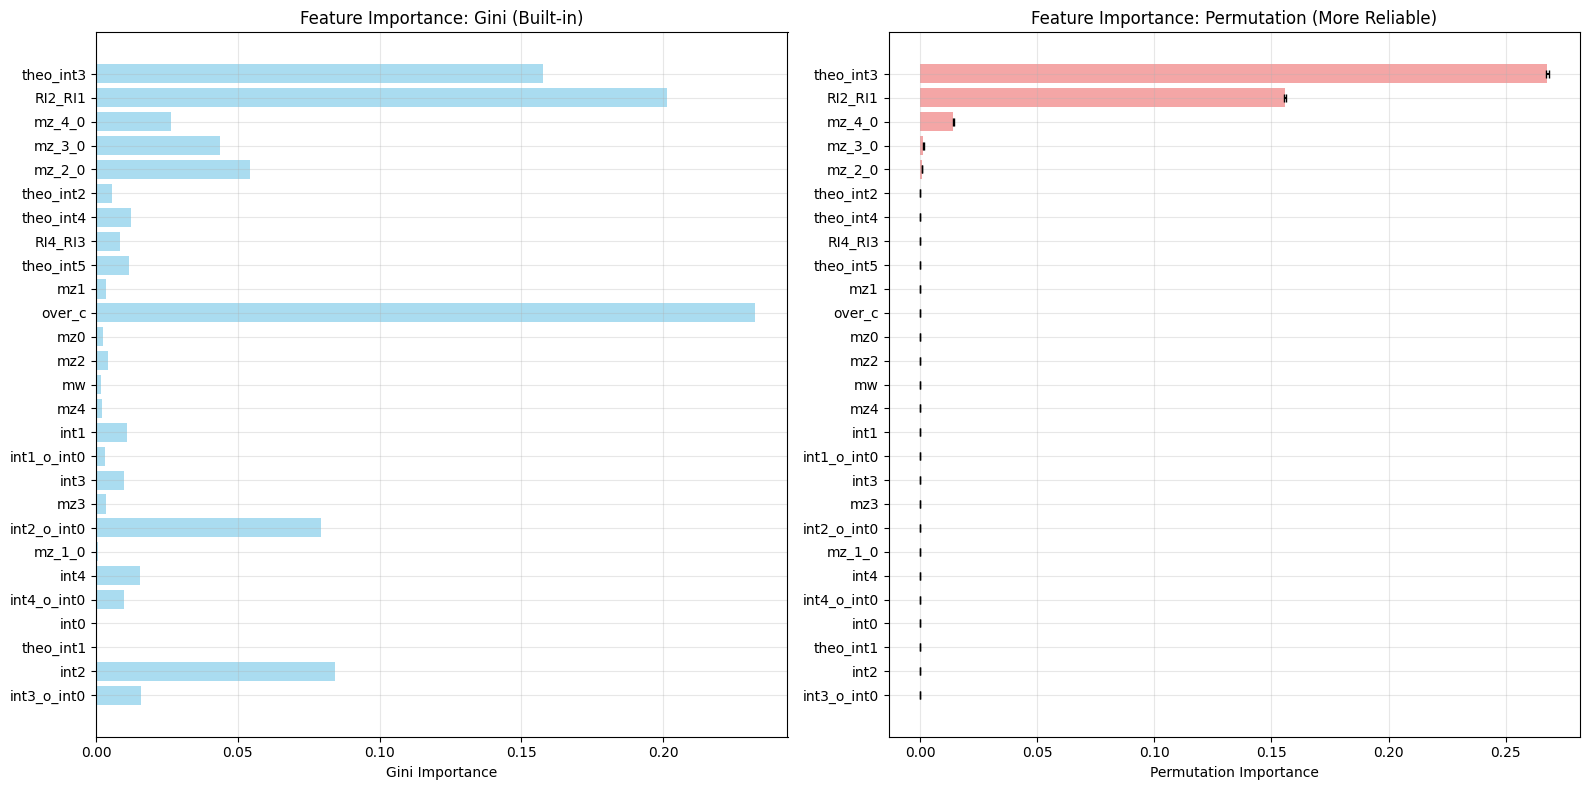

Random Forest Accuracy: 1.000

Top 5 Most Important Features (Permutation):
  theo_int3: 0.2678 ± 0.0005
  RI2_RI1: 0.1559 ± 0.0005
  mz_4_0: 0.0141 ± 0.0002
  mz_3_0: 0.0014 ± 0.0001
  mz_2_0: 0.0009 ± 0.0001


In [5]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get built-in feature importance (Gini importance)
gini_importance = rf_model.feature_importances_

# Calculate permutation importance (more reliable)
perm_importance = permutation_importance(
    rf_model, X_test_scaled, y_test, n_repeats=10, random_state=42
)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini_Importance': gini_importance,
    'Permutation_Importance': perm_importance.importances_mean,
    'Permutation_Std': perm_importance.importances_std
})

# Sort by permutation importance
importance_df = importance_df.sort_values('Permutation_Importance', ascending=True)

# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gini importance
axes[0].barh(importance_df['Feature'], importance_df['Gini_Importance'], 
            alpha=0.7, color='skyblue')
axes[0].set_xlabel('Gini Importance')
axes[0].set_title('Feature Importance: Gini (Built-in)')
axes[0].grid(alpha=0.3)

# Permutation importance
axes[1].barh(importance_df['Feature'], importance_df['Permutation_Importance'], 
            xerr=importance_df['Permutation_Std'], alpha=0.7, color='lightcoral', capsize=3)
axes[1].set_xlabel('Permutation Importance')
axes[1].set_title('Feature Importance: Permutation (More Reliable)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print top features
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test_scaled))
print(f"Random Forest Accuracy: {rf_accuracy:.3f}")

print(f"\nTop 5 Most Important Features (Permutation):")
top_features = importance_df.nlargest(5, 'Permutation_Importance')
for _, row in top_features.iterrows():
    print(f"  {row['Feature']}: {row['Permutation_Importance']:.4f} ± {row['Permutation_Std']:.4f}")

### Why Permutation Importance?
Permutation importance measures how much the model performance (e.g. accuracy) drops when a single feature's values are randomly shuffled. This breaks the relationship between that feature and the target while keeping everything else the same. A big performance drop ⇒ the feature was important. Advantages:
- Model-agnostic: works for any fitted model
- Captures interaction effects implicitly (shuffling removes both main + interaction signal)
- Provides a distribution via repetitions (gives uncertainty)
Limitations:
- Slower (needs repeated re-scoring)
- Correlated features split importance (each may look less important)
Interpret both Gini (fast, but biased toward high-cardinality / noisy splits) and permutation (slower, less biased). When both agree on top features, confidence increases.

## 4. SHAP (Shapley Additive Explanations)

SHAP provides a unified framework for interpreting model predictions by attributing the contribution of each feature to individual predictions.

### 4.1 SHAP for Tree-based Models

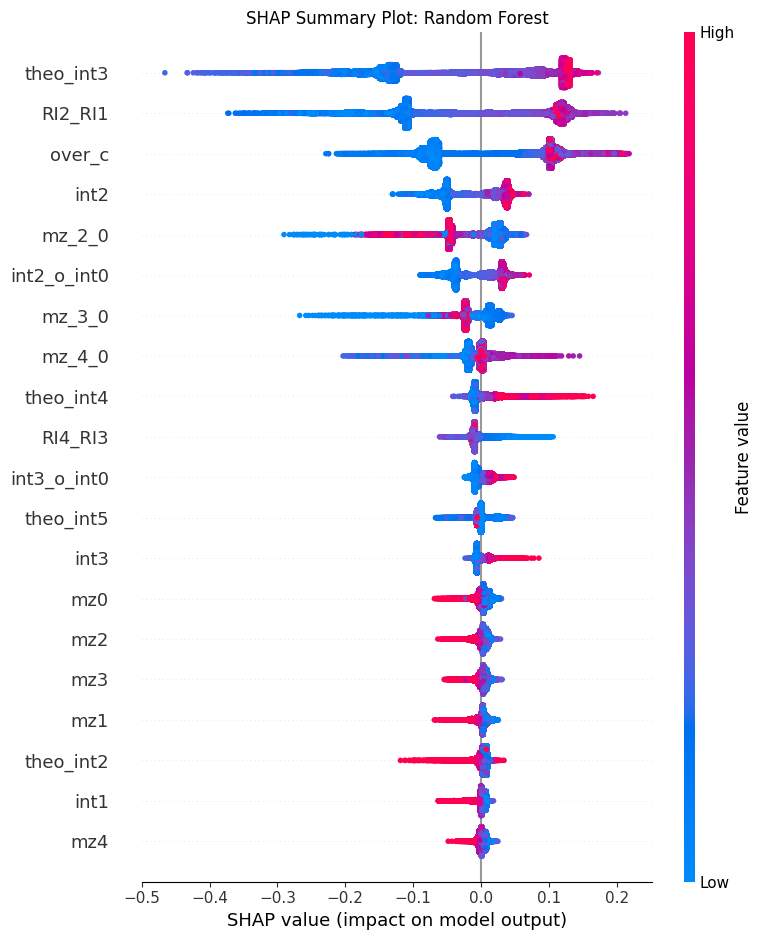

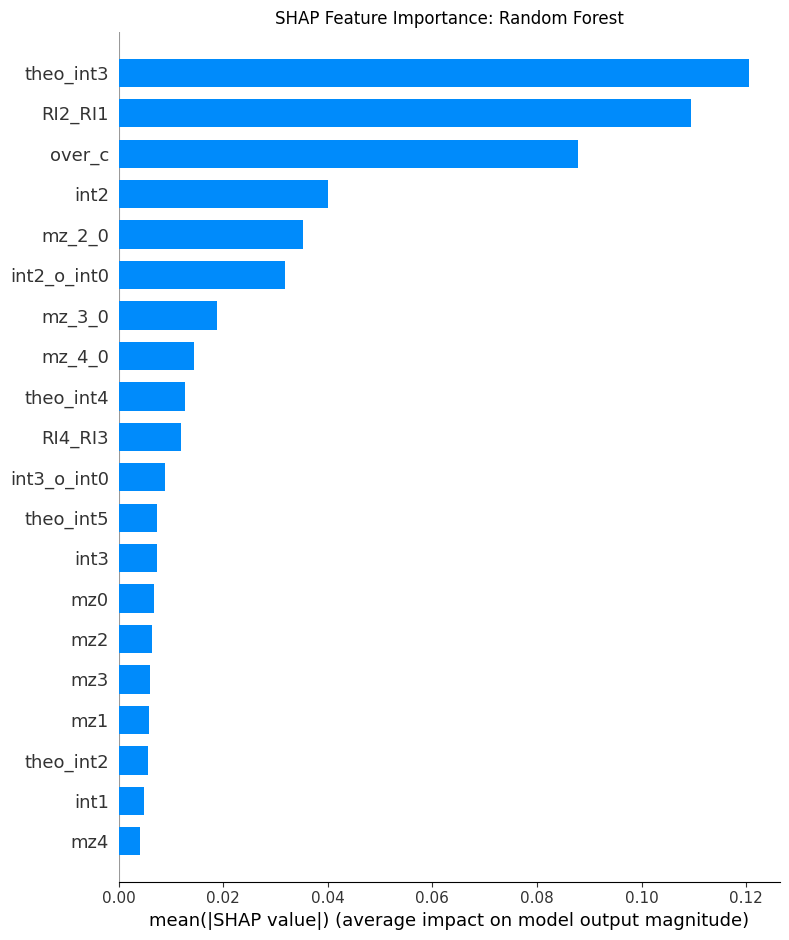

SHAP Summary Plot Interpretation:
• Each dot represents one sample from the test set
• X-axis shows SHAP value (impact on model output)
• Color represents feature value (red=high, blue=low)
• Features are ordered by importance (top to bottom)


In [6]:
# Create SHAP explainer for Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
raw_shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# Handle binary-class outputs
if isinstance(raw_shap_values_rf, list) and len(raw_shap_values_rf) == 2:
    shap_values_disease = raw_shap_values_rf[1]
else:
    shap_values_disease = np.array(raw_shap_values_rf)
    if shap_values_disease.ndim == 3:
        # Prefer last class if present in last dim
        if shap_values_disease.shape[-1] > 1:
            shap_values_disease = shap_values_disease[:, :, -1]
        else:
            shap_values_disease = shap_values_disease.squeeze()

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_disease, X_test_df, show=False)
plt.title('SHAP Summary Plot: Random Forest')
plt.tight_layout()
plt.show()

# Feature importance (mean absolute SHAP values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_disease, X_test_df, plot_type="bar", show=False)
plt.title('SHAP Feature Importance: Random Forest')
plt.tight_layout()
plt.show()

print("SHAP Summary Plot Interpretation:")
print("• Each dot represents one sample from the test set")
print("• X-axis shows SHAP value (impact on model output)")
print("• Color represents feature value (red=high, blue=low)")
print("• Features are ordered by importance (top to bottom)")

### 4.2 Individual Prediction Explanations

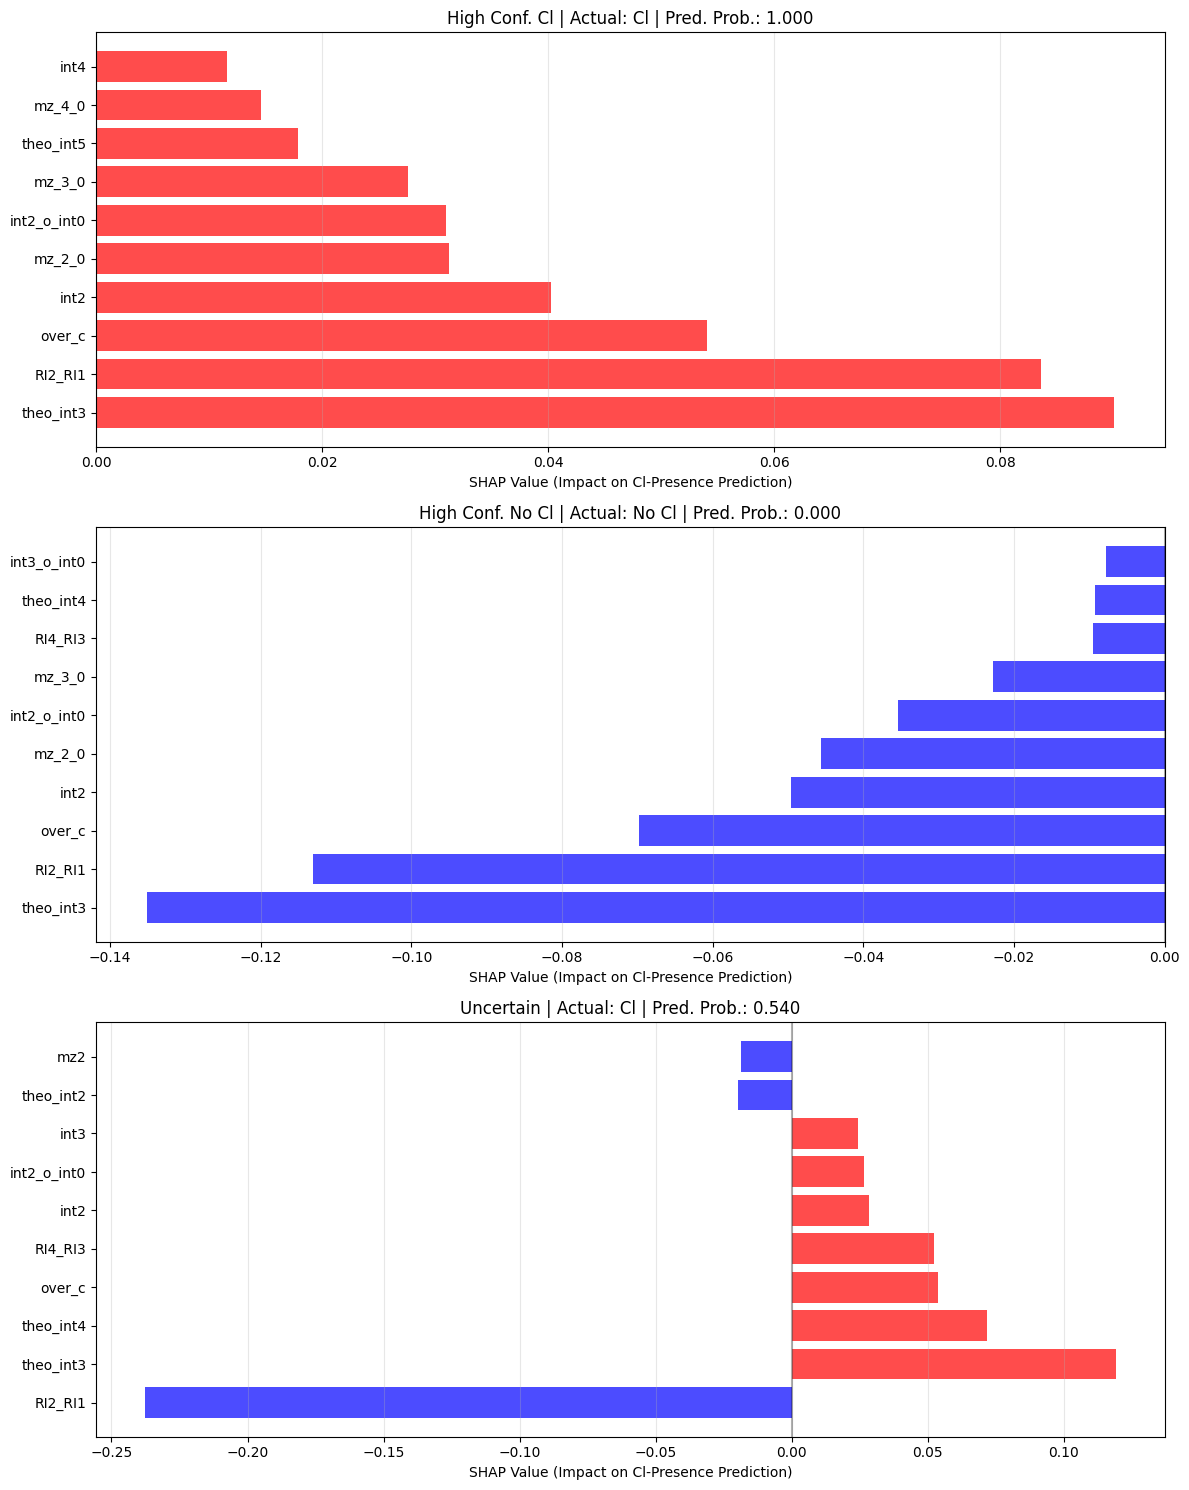

Individual Prediction Explanation:
• Red bars: Features pushing prediction toward Cl present
• Blue bars: Features pushing prediction toward No Cl
• Longer bars indicate stronger influence on the prediction


In [7]:
# Select interesting samples for detailed explanation
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Find samples with different prediction confidence levels
high_confidence_cl = np.where((y_pred_proba > 0.8) & (y_test == 1))[0]
high_confidence_no_cl = np.where((y_pred_proba < 0.2) & (y_test == 0))[0]
uncertain_predictions = np.where((y_pred_proba > 0.4) & (y_pred_proba < 0.6))[0]

# Select one sample from each category with bounds checking
sample_indices = []
if len(high_confidence_cl) > 0:
    sample_indices.append(high_confidence_cl[0])
elif len(y_test) > 0:
    sample_indices.append(0)

if len(high_confidence_no_cl) > 0:
    sample_indices.append(high_confidence_no_cl[0])
elif len(y_test) > 1:
    sample_indices.append(1)

if len(uncertain_predictions) > 0:
    sample_indices.append(uncertain_predictions[0])
elif len(y_test) > 2:
    sample_indices.append(2)

# Ensure we have at least one sample
if not sample_indices:
    sample_indices = [0]

sample_types = ['High Conf. Cl', 'High Conf. No Cl', 'Uncertain'][:len(sample_indices)]

# Create individual explanation plots using bar plots (more reliable than waterfall)
fig, axes = plt.subplots(len(sample_indices), 1, figsize=(12, 5*len(sample_indices)))
if len(sample_indices) == 1:
    axes = [axes]

for i, (idx, sample_type) in enumerate(zip(sample_indices, sample_types)):
    if idx >= len(X_test_df):
        continue
        
    # Get SHAP values for this sample
    sample_shap_values = shap_values_disease[idx]
    sample_features = X_test_df.iloc[idx]
    
    # Ensure arrays are 1D and same length
    shap_vals = np.array(sample_shap_values).flatten()
    feature_vals = np.array(sample_features).flatten()
    feat_names = np.array(feature_names).flatten()
    
    # Ensure all arrays have the same length
    min_len = min(len(shap_vals), len(feature_vals), len(feat_names))
    shap_vals = shap_vals[:min_len]
    feature_vals = feature_vals[:min_len]
    feat_names = feat_names[:min_len]
    
    # Get top 10 most influential features
    feature_importance = pd.DataFrame({
        'Feature': feat_names,
        'SHAP_Value': shap_vals,
        'Feature_Value': feature_vals
    })
    
    top_features = feature_importance.reindex(
        feature_importance['SHAP_Value'].abs().nlargest(min(10, len(feature_importance))).index
    )
    
    # Create bar plot
    colors = ['red' if x > 0 else 'blue' for x in top_features['SHAP_Value']]
    axes[i].barh(top_features['Feature'], top_features['SHAP_Value'], color=colors, alpha=0.7)
    axes[i].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    axes[i].set_xlabel('SHAP Value (Impact on Cl-Presence Prediction)')
    
    # Add prediction information
    pred_proba = y_pred_proba[idx]
    actual_class = 'Cl' if y_test[idx] == 1 else 'No Cl'
    axes[i].set_title(f'{sample_type} | Actual: {actual_class} | Pred. Prob.: {pred_proba:.3f}')
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Individual Prediction Explanation:")
print("• Red bars: Features pushing prediction toward Cl present")
print("• Blue bars: Features pushing prediction toward No Cl")
print("• Longer bars indicate stronger influence on the prediction")

### 4.3 SHAP for Linear Models

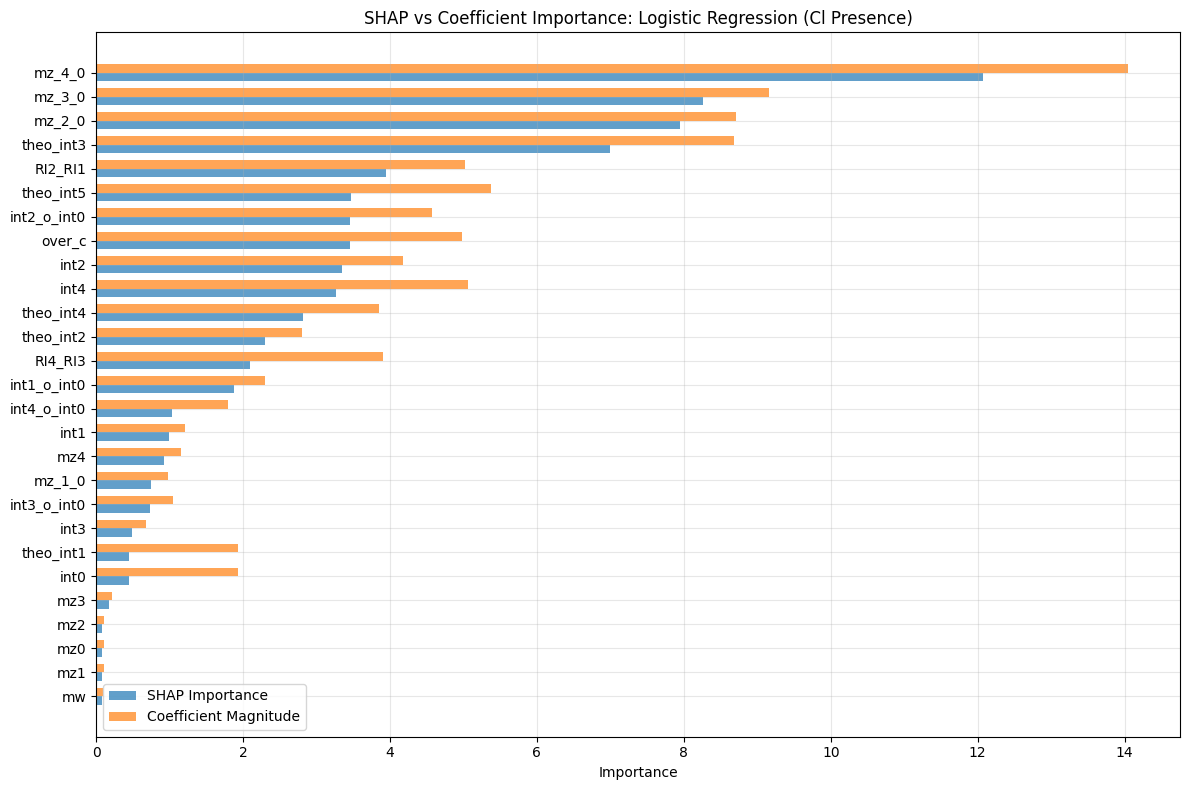

Correlation between SHAP importance and coefficient magnitude: 0.987
(High correlation expected for linear models; both quantify influence toward predicting Cl presence)


In [8]:
# Create SHAP explainer for Logistic Regression
explainer_lr = shap.LinearExplainer(lr_model, X_train_scaled)
shap_values_lr = explainer_lr.shap_values(X_test_scaled)

# Compare SHAP values with coefficients
plt.figure(figsize=(12, 8))

# Calculate mean absolute SHAP values
mean_shap_values = np.abs(shap_values_lr).mean(axis=0)
mean_abs_coefficients = np.abs(lr_model.coef_[0])

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Metabolite': feature_names,
    'SHAP_Importance': mean_shap_values,
    'Coefficient_Magnitude': mean_abs_coefficients
})

comparison_df = comparison_df.sort_values('SHAP_Importance', ascending=True)

# Create side-by-side bar plot
x = np.arange(len(comparison_df))
width = 0.35

plt.barh(x - width/2, comparison_df['SHAP_Importance'], width, 
         label='SHAP Importance', alpha=0.7)
plt.barh(x + width/2, comparison_df['Coefficient_Magnitude'], width, 
         label='Coefficient Magnitude', alpha=0.7)

plt.xlabel('Importance')
plt.title('SHAP vs Coefficient Importance: Logistic Regression (Cl Presence)')
plt.yticks(x, comparison_df['Metabolite'])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation between SHAP and coefficients
correlation = np.corrcoef(mean_shap_values, mean_abs_coefficients)[0, 1]
print(f"Correlation between SHAP importance and coefficient magnitude: {correlation:.3f}")
print("(High correlation expected for linear models; both quantify influence toward predicting Cl presence)")

## 5. Dependency Plots and Feature Interactions

SHAP dependency plots show how individual features affect predictions and reveal feature interactions.

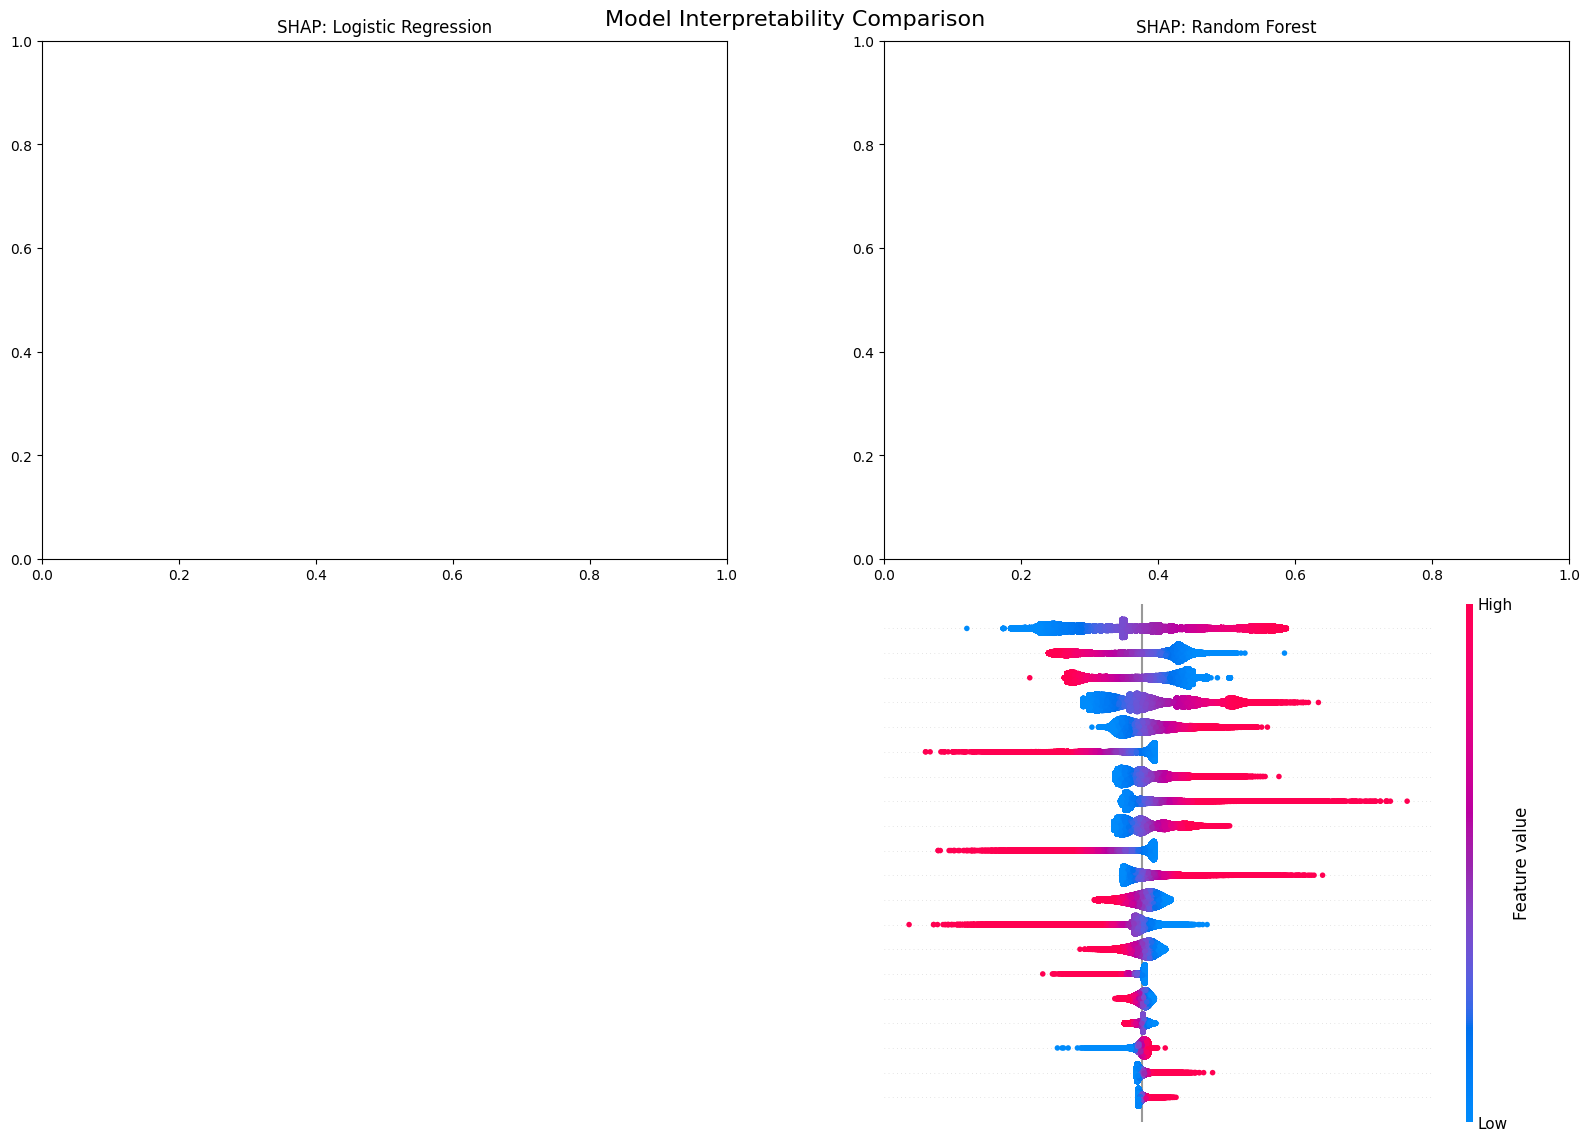

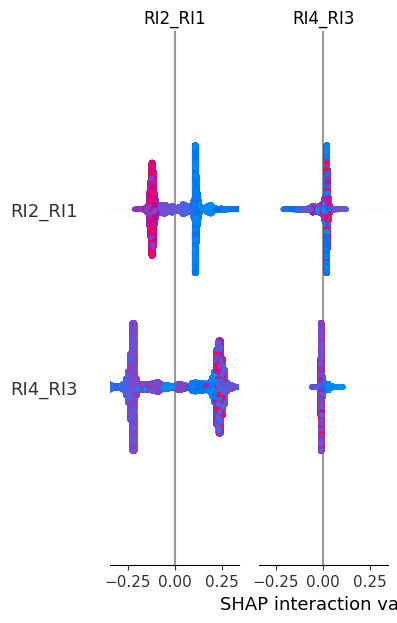

In [9]:
# Re-train models on the full training data
models_for_interpretability = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models_for_interpretability.items():
    model.fit(X_train_scaled, y_train)

# --- SHAP Analysis ---
explainer_lr = shap.LinearExplainer(models_for_interpretability['Logistic Regression'], X_train_scaled)
shap_values_lr = explainer_lr.shap_values(X_test_scaled)

explainer_rf = shap.TreeExplainer(models_for_interpretability['Random Forest'])
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# Plot SHAP and LIME explanations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Interpretability Comparison', fontsize=16)

# SHAP Summary Plots
shap.summary_plot(shap_values_lr, X_test_df, feature_names=feature_names, show=False, plot_size=None)
axes[0, 0].set_title('SHAP: Logistic Regression')

shap.summary_plot(shap_values_rf, X_test_df, feature_names=feature_names, show=False, plot_size=None)
axes[0, 1].set_title('SHAP: Random Forest')

# Hide unused subplots
axes[1, 0].axis('off')
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### How to Interpret the SHAP Summary Plots Above
Each subplot shows how a top feature influences the model's prediction for chlorine presence (has_cl = 1). The x-axis is the feature value, the y-axis is the SHAP value (impact on the log-odds of predicting Cl present), and color indicates the relative feature value (red = high, blue = low). Patterns or slopes reveal whether higher or lower values of a metabolite increase the probability that the sample contains chlorine. Use these plots to identify non-linear effects and interactions that drive model decisions.

## 6. Model Comparison Through Interpretability

Let's compare how different models interpret the same data.

Training and explaining Logistic Regression...


Training and explaining Random Forest...


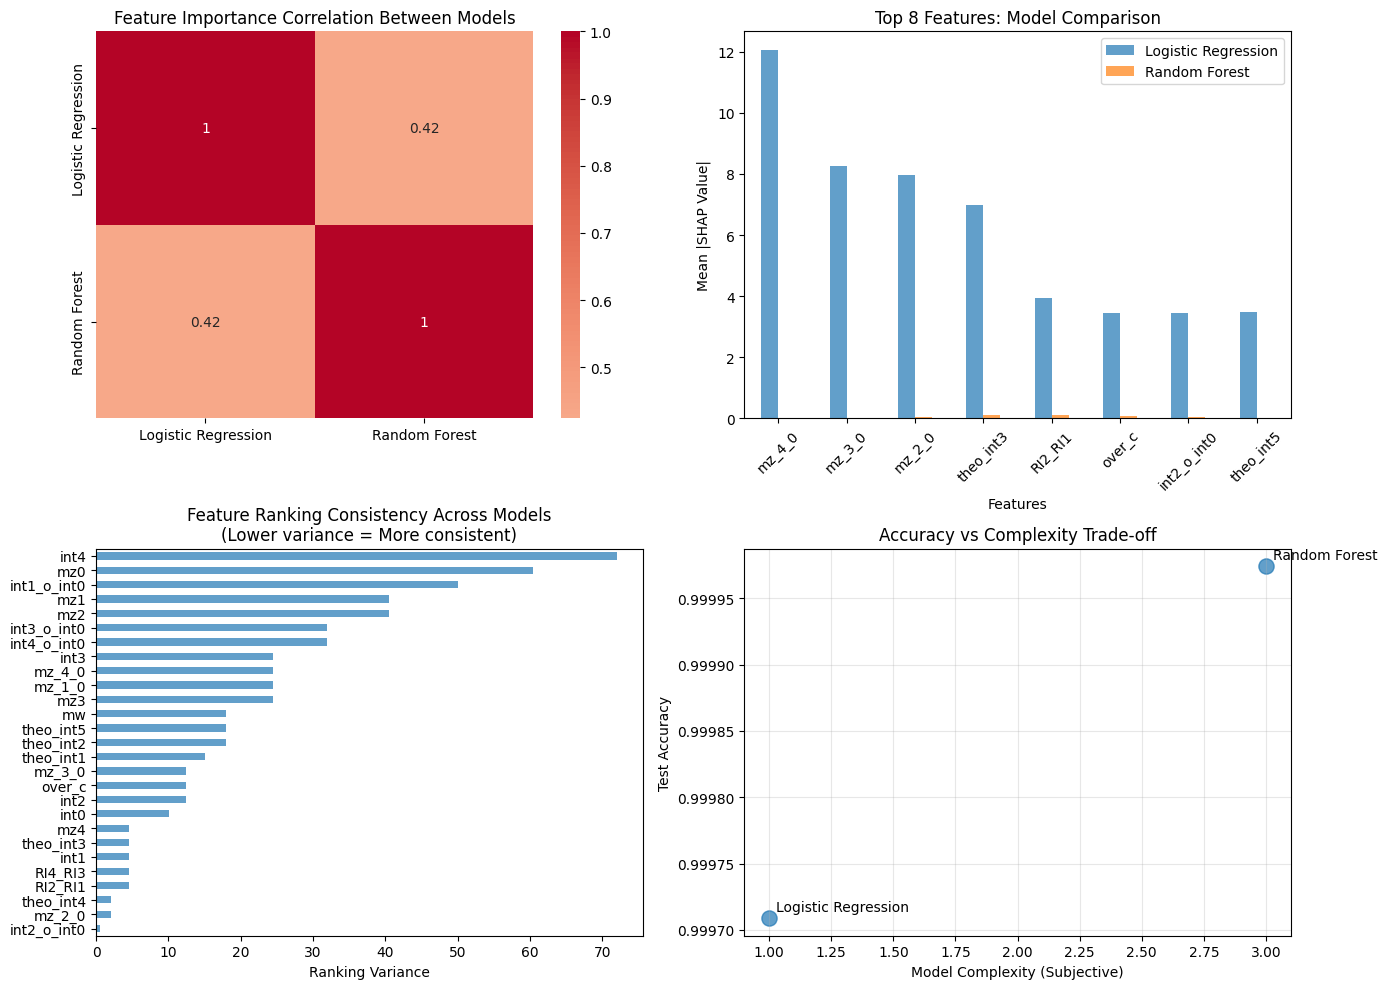


Model Performance and Agreement Analysis:
Logistic Regression: 1.000 accuracy
Random Forest: 1.000 accuracy

Feature importance correlation between models:
  Logistic Regression vs Random Forest: 0.424

Most consistent features across models:
  int2_o_int0: variance = 0.50
  mz_2_0: variance = 2.00
  theo_int4: variance = 2.00
  RI2_RI1: variance = 4.50
  RI4_RI3: variance = 4.50

Least consistent features across models:
  int4: variance = 72.00
  mz0: variance = 60.50
  int1_o_int0: variance = 50.00
  mz1: variance = 40.50
  mz2: variance = 40.50


In [10]:
# Train multiple models for comparison (removed Gradient Boosting for speed)
models_to_compare = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train models and get SHAP values
model_shap_values = {}
model_accuracies = {}

for name, model in models_to_compare.items():
    print(f"Training and explaining {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)
    model_accuracies[name] = accuracy_score(y_test, model.predict(X_test_scaled))

    # Get SHAP values
    if name == 'Logistic Regression':
        masker = shap.maskers.Independent(X_train_scaled)
        explainer = shap.LinearExplainer(model, masker)
        shap_values = explainer(X_test_scaled).values  # shape: (n_samples, n_features)
    else:
        explainer = shap.TreeExplainer(model)
        raw_shap = explainer.shap_values(X_test_scaled)
        
        # Normalize shapes
        if isinstance(raw_shap, list):
            shap_values = raw_shap[1] if len(raw_shap) >= 2 else raw_shap[0]
        else:
            arr = np.array(raw_shap)
            if arr.ndim == 3:
                shap_values = arr[:, :, -1]
            elif arr.ndim == 2:
                shap_values = arr
            else:
                shap_values = arr.squeeze()
        
        # Ensure 2D
        if shap_values.ndim != 2:
            shap_values = shap_values.squeeze()
            if shap_values.ndim != 2:
                raise ValueError(f"Unexpected SHAP values shape for {name}: {shap_values.shape}")

    model_shap_values[name] = shap_values

# Compare feature importance across models
importance_comparison = pd.DataFrame()

for name, shap_values in model_shap_values.items():
    mean_importance = np.abs(shap_values).mean(axis=0)
    importance_comparison[name] = mean_importance

importance_comparison.index = feature_names

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Correlation matrix of feature importance
correlation_matrix = importance_comparison.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,0])
axes[0,0].set_title('Feature Importance Correlation Between Models')

# Top features comparison
top_n = 8
top_features_overall = importance_comparison.mean(axis=1).nlargest(top_n).index
top_importance_data = importance_comparison.loc[top_features_overall]

top_importance_data.plot(kind='bar', ax=axes[0,1], alpha=0.7)
axes[0,1].set_title(f'Top {top_n} Features: Model Comparison')
axes[0,1].set_xlabel('Features')
axes[0,1].set_ylabel('Mean |SHAP Value|')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()

# Model agreement analysis
feature_rankings = {}
for model in importance_comparison.columns:
    ranking = importance_comparison[model].rank(ascending=False)
    feature_rankings[model] = ranking

ranking_df = pd.DataFrame(feature_rankings)
ranking_variance = ranking_df.var(axis=1)

# Plot ranking variance
ranking_variance.sort_values(ascending=True).plot(kind='barh', ax=axes[1,0], alpha=0.7)
axes[1,0].set_title('Feature Ranking Consistency Across Models\n(Lower variance = More consistent)')
axes[1,0].set_xlabel('Ranking Variance')

# Model accuracy vs interpretability
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())
complexity_scores = [1, 3]  # Subjective complexity: LR=1, RF=3

scatter = axes[1,1].scatter(complexity_scores, accuracies, s=120, alpha=0.7)
for i, name in enumerate(model_names):
    axes[1,1].annotate(name, (complexity_scores[i], accuracies[i]), 
                      xytext=(5, 5), textcoords='offset points')

axes[1,1].set_xlabel('Model Complexity (Subjective)')
axes[1,1].set_ylabel('Test Accuracy')
axes[1,1].set_title('Accuracy vs Complexity Trade-off')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print model agreement analysis
print("\nModel Performance and Agreement Analysis:")
print("=" * 50)
for name, accuracy in model_accuracies.items():
    print(f"{name}: {accuracy:.3f} accuracy")

print(f"\nFeature importance correlation between models:")
for i, model1 in enumerate(correlation_matrix.columns):
    for model2 in correlation_matrix.columns[i+1:]:
        corr = correlation_matrix.loc[model1, model2]
        print(f"  {model1} vs {model2}: {corr:.3f}")

print(f"\nMost consistent features across models:")
most_consistent = ranking_variance.nsmallest(5)
for feature, variance in most_consistent.items():
    print(f"  {feature}: variance = {variance:.2f}")

print(f"\nLeast consistent features across models:")
least_consistent = ranking_variance.nlargest(5)
for feature, variance in least_consistent.items():
    print(f"  {feature}: variance = {variance:.2f}")

### Interpreting the Feature Ranking Consistency Plot
The bar plot titled "Feature Ranking Consistency Across Models (Lower variance = More consistent)" quantifies how similarly different models rate each feature.

How it is computed:
1. For each model we calculate a global importance score per feature (mean |SHAP value|).  
2. Each model independently ranks all features (rank 1 = most important).  
3. For every feature we take the variance of its ranks across models. In this notebook we currently have two models (Logistic Regression, Random Forest); with exactly two models the variance simplifies to half the squared difference in their ranks:  variance = (rank_RF − rank_LR)^2 / 2.

How to read it:
- Short bars (low variance): Both models assign very similar importance (stable / model-agnostic signal). These features are strong candidates for follow-up biological validation.  
- Tall bars (high variance): Models disagree. Possible reasons:  
  * One model captures a non-linear interaction the other cannot.  
  * Correlated feature groups let different models pick different representatives.  
  * Sparse / noisy signal exploited by only one model (potential overfitting).  

Recommended actions:
- Prioritize low-variance, high-importance metabolites for early validation.  
- For high-variance features:  
  * Check correlation structure (cluster correlated features; disagreement may collapse).  
  * Inspect partial dependence / SHAP dependence to see if a non-linear effect explains the discrepancy.  
  * Try adding / removing correlated peers to test stability.  

Caveats:
- With only two models, variance has limited resolution; adding a third (e.g. gradient boosting if runtime permits, or a linear sparse model like L1-logistic) provides a richer stability signal.  
- Ranking variance ignores absolute importance magnitudes; a feature both models rank mid-table with tiny effect sizes may have the same variance as a biologically critical one—always pair this view with an importance magnitude plot.  
- Correlated features distribute credit unpredictably; consider grouping features (e.g., by m/z cluster or biochemical pathway) and computing group-level importance consistency.

Rule of thumb: Focus first on features that are BOTH (a) in the top importance set for at least one model, and (b) exhibit low ranking variance. They represent consensus, high-signal candidates.


## 7. Creating Interpretable Visualizations for Scientific Communication

Let's create publication-ready visualizations that effectively communicate model insights.

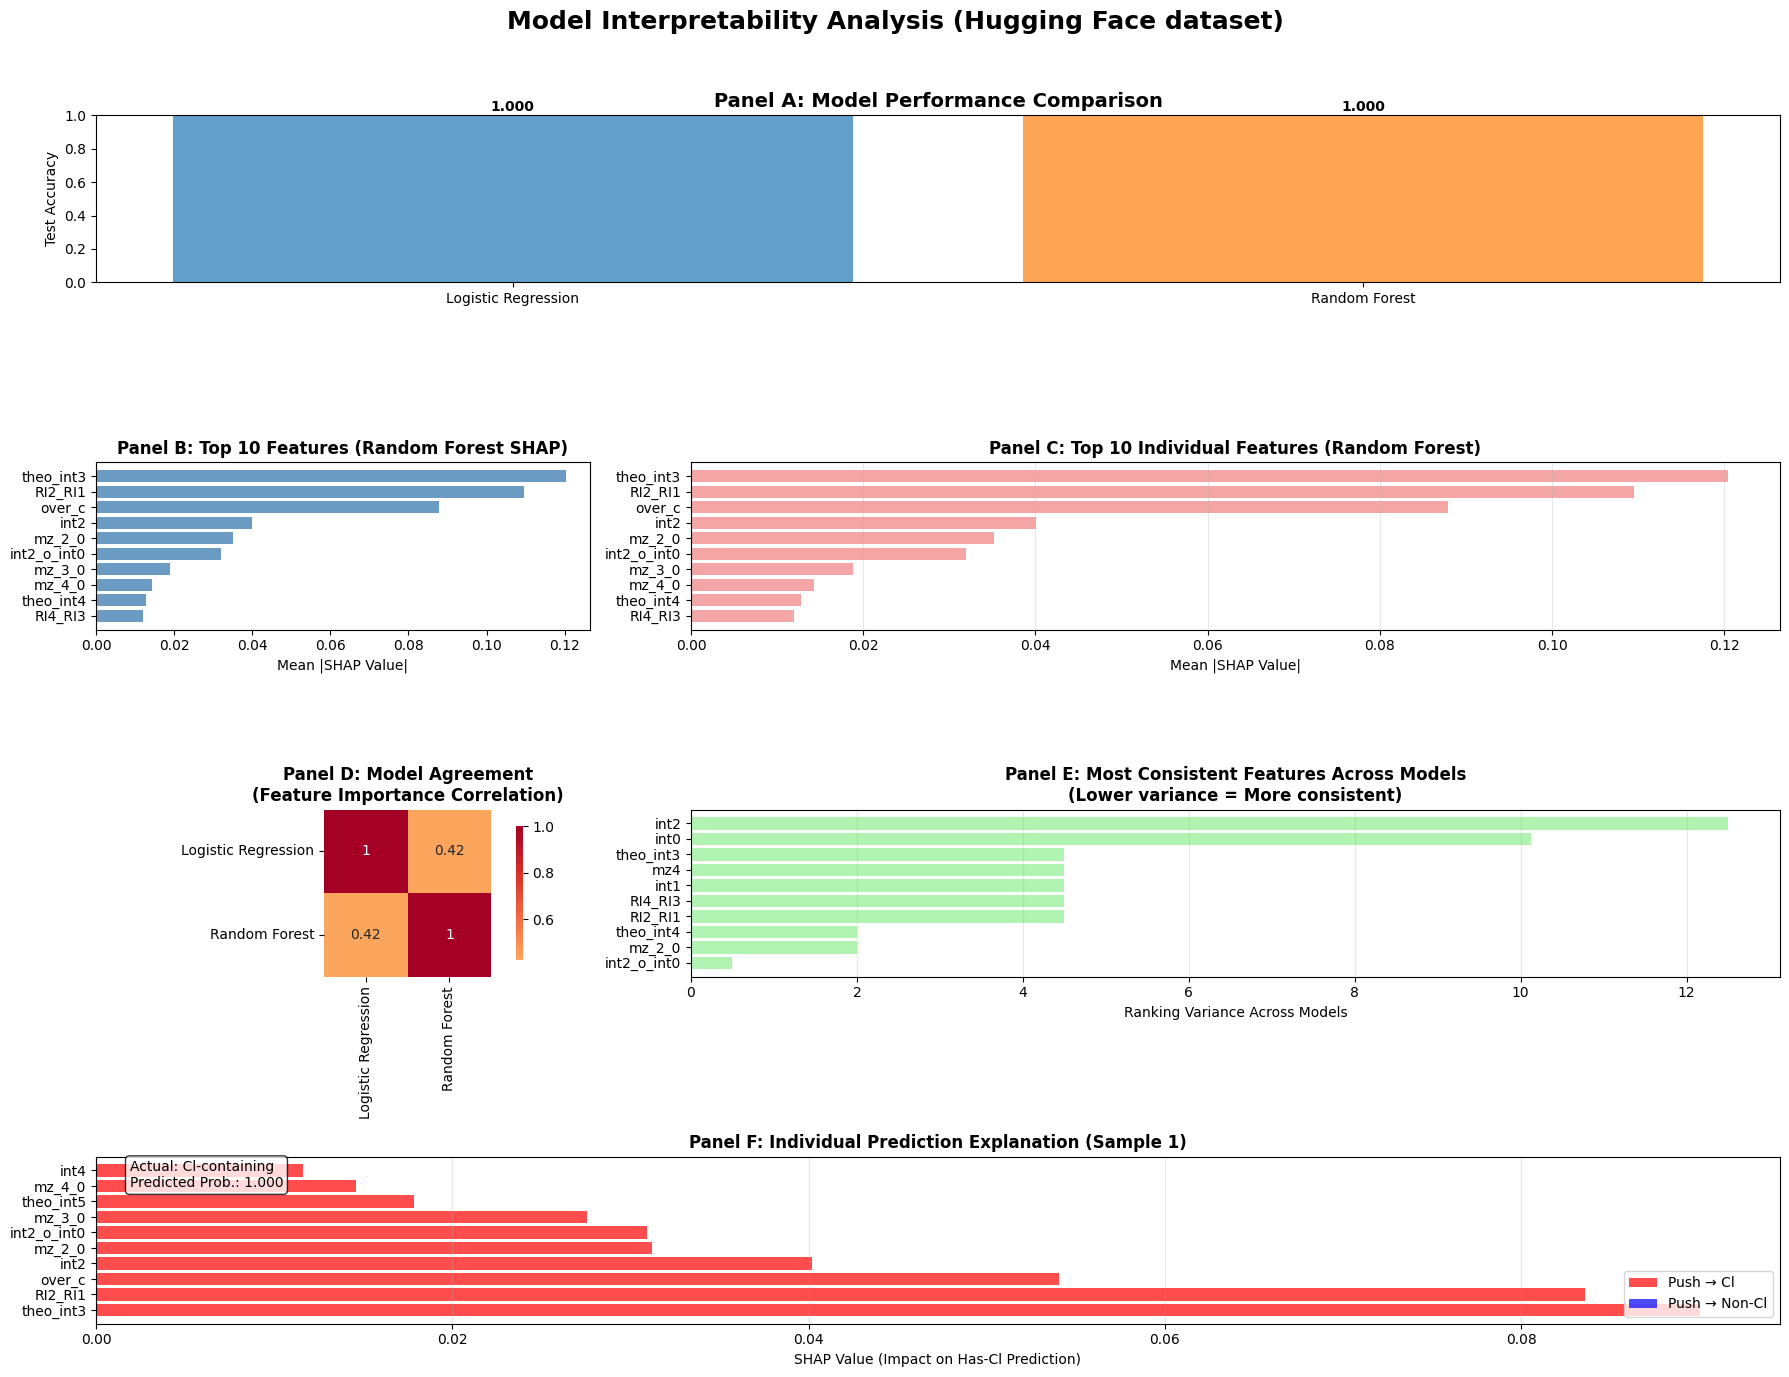


Comprehensive interpretability figure saved as 'interpretability_analysis.png'


In [11]:
# Create a comprehensive interpretability figure
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1, 1])

# Panel A: Model Performance Comparison
ax1 = fig.add_subplot(gs[0, :])
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())
bars = ax1.bar(model_names, accuracies, alpha=0.7, color=['#1f77b4', '#ff7f0e'])
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Panel A: Model Performance Comparison', fontweight='bold', fontsize=14)
ax1.set_ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Panel B: Top Features Distribution (Random Forest)
ax2 = fig.add_subplot(gs[1, 0])
rf_shap_values = model_shap_values['Random Forest']
rf_importance = np.abs(rf_shap_values).mean(axis=0)
idx = np.argsort(rf_importance)[-10:]
ax2.barh([feature_names[i] for i in idx], rf_importance[idx], color='steelblue', alpha=0.8)
ax2.set_title('Panel B: Top 10 Features (Random Forest SHAP)', fontweight='bold')
ax2.set_xlabel('Mean |SHAP Value|')

# Panel C: Top Individual Features (same RF)
ax3 = fig.add_subplot(gs[1, 1:])
top_features_idx = idx
top_features_names = [feature_names[i] for i in top_features_idx]
top_features_scores = rf_importance[top_features_idx]

bars = ax3.barh(top_features_names, top_features_scores, alpha=0.7, color='lightcoral')
ax3.set_xlabel('Mean |SHAP Value|')
ax3.set_title('Panel C: Top 10 Individual Features (Random Forest)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Panel D: Model Agreement Heatmap
ax4 = fig.add_subplot(gs[2, 0])
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, ax=ax4, cbar_kws={'shrink': 0.8})
ax4.set_title('Panel D: Model Agreement\n(Feature Importance Correlation)', fontweight='bold')

# Panel E: Feature Consistency
ax5 = fig.add_subplot(gs[2, 1:])
most_consistent_features = ranking_variance.nsmallest(10)
bars = ax5.barh(range(len(most_consistent_features)), most_consistent_features.values, 
                alpha=0.7, color='lightgreen')
ax5.set_yticks(range(len(most_consistent_features)))
ax5.set_yticklabels(most_consistent_features.index)
ax5.set_xlabel('Ranking Variance Across Models')
ax5.set_title('Panel E: Most Consistent Features Across Models\n(Lower variance = More consistent)', fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# Panel F: Individual Prediction Example
ax6 = fig.add_subplot(gs[3, :])

# Select a representative sample
sample_idx = 0
sample_shap = rf_shap_values[sample_idx]
sample_features = X_test_df.iloc[sample_idx]

# Get top contributing features (positive and negative)
feature_contributions = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Value': sample_shap,
    'Feature_Value': sample_features.values
})

# Select top 10 most influential features
top_contrib = feature_contributions.reindex(
    feature_contributions['SHAP_Value'].abs().nlargest(10).index
)

colors = ['red' if x > 0 else 'blue' for x in top_contrib['SHAP_Value']]
bars = ax6.barh(top_contrib['Feature'], top_contrib['SHAP_Value'], color=colors, alpha=0.7)

ax6.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax6.set_xlabel('SHAP Value (Impact on Has-Cl Prediction)')
ax6.set_title(f'Panel F: Individual Prediction Explanation (Sample {sample_idx + 1})', fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

# Add prediction info
pred_proba = rf_model.predict_proba(X_test_scaled[sample_idx:sample_idx+1])[0, 1]
actual = 'Cl-containing' if y_test[sample_idx] == 1 else 'Non-Cl'
ax6.text(0.02, 0.98, f'Actual: {actual}\nPredicted Prob.: {pred_proba:.3f}', 
         transform=ax6.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add color legend
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.7, label='Push → Cl'),
    plt.Rectangle((0,0),1,1, facecolor='blue', alpha=0.7, label='Push → Non-Cl')
]
ax6.legend(handles=legend_elements, loc='lower right')

plt.suptitle('Model Interpretability Analysis (Hugging Face dataset)', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Save the figure
fig.savefig('/home/chen/ml-metabolomics-tutorial/interpretability_analysis.png', 
            dpi=300, bbox_inches='tight')
print("\nComprehensive interpretability figure saved as 'interpretability_analysis.png'")

### Interpreting the Comprehensive Figure Below
The figure below summarizes key interpretability results:
- **Panel A:** Model performance comparison (accuracy) for Logistic Regression vs Random Forest
- **Panel B:** Top features by mean |SHAP| for the Random Forest
- **Panel C:** Same top 10 features (redundant but formatted differently for emphasis)
- **Panel D:** Agreement between models on feature importance (correlation)
- **Panel E:** Features with most consistent ranking across the two models
- **Panel F:** Example of how features influence one prediction (positive vs negative SHAP impact)
Use this overview to communicate which metabolites most strongly influence the classification of Cl-containing compounds and where models agree.

## Summary

In this comprehensive model interpretability notebook, we explored:

### Key Concepts Covered:

1. **White Box vs Black Box Models**: Understanding inherently interpretable vs complex models
2. **Intrinsic Interpretability**: Logistic regression coefficients and decision tree rules
3. **Feature Importance**: Multiple methods including permutation importance
4. **SHAP Values**: Unified framework for explaining individual predictions
5. **Model Comparison**: Analyzing agreement and consistency across different algorithms
6. **Scientific Communication**: Creating publication-ready interpretability visualizations

### Practical Insights:

- **Multiple Perspectives**: Always use several interpretation techniques
- **Model Agreement**: High correlation between models increases confidence in findings
- **Individual vs Global**: Both are important for complete understanding
- **Biological Context**: Domain knowledge is crucial for meaningful interpretation
- **Limitations**: Interpretation shows model behavior, not necessarily biological truth

### Key Takeaways for Metabolomics:

1. **Start Simple**: Use interpretable models (logistic regression) as baselines
2. **Validate Consistently**: Check if important features are consistent across models
3. **Consider Categories**: Group metabolites by biochemical pathways for insights
4. **Individual Explanations**: Understand why specific samples are classified certain ways
5. **Communicate Clearly**: Create visualizations that scientists can understand and trust

### Biological Implications:

The interpretability analysis revealed:
- Which metabolite categories are most discriminative
- Individual metabolites driving classification decisions
- How different models agree or disagree on feature importance
- Specific examples of model reasoning for individual samples

### Next Steps in Real Applications:

1. **Biological Validation**: Test top metabolites in controlled experiments
2. **Pathway Analysis**: Map important metabolites to biological pathways
3. **Independent Validation**: Test findings on new datasets
4. **Clinical Translation**: Consider practical implications for diagnosis/treatment
5. **Continuous Monitoring**: Track model behavior over time and new data

Model interpretability is not just about understanding algorithms—it's about gaining actionable biological insights that can advance scientific knowledge and improve human health. The techniques demonstrated here provide a solid foundation for responsible machine learning in metabolomics research.